# FinOpt: Complete Workflow Validation

# Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

import matplotlib.pyplot as plt

# --- Standard libs ---
import numpy as np
import pandas as pd

# --- FinOpt modules (desde /src) ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel
from src.utils import monthly_to_annual
from src.model import FinancialModel, SimulationResult

# Configuration: Seasonality and Contribution

In [2]:
# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---

# Structure: months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
#                      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

seasonality_variable = [0.00, 0.00, 0.00, 1.32, 1.32, 1.36,
                        1.24, 1.10, 0.50, 0.90, 1.00, 1.31]

monthly_contrib_fixed = [0.20, 0.20, 0.20, 0.22, 0.25, 0.25,
                         0.23, 0.23, 0.20, 0.20, 0.20, 0.10]

monthly_contrib_variable = [1.0] * 12

# Initialize FinancialModel 

In [3]:
# IncomeModel Instantiation
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # CLP/month
        annual_growth=0.03,     # 3% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # +400k in April 2026
            date(2027, 4, 1): 400_000   # +400k in April 2027
        },
        name="fixed"
    ),
    variable=VariableIncome(
        base=150_000.0,         # Base variable income
        seasonality=seasonality_variable,
        sigma=0.10,             # 10% monthly noise
        floor=0.0,              # No negative income
        cap=400_000.0,          # Maximum 400k/month
        annual_growth=0.0,      # No growth in variable
        name="variable"
    ),
)

# --- Define contribution strategy ---
income.monthly_contribution = {
    "fixed": monthly_contrib_fixed,  # Custom monthly fractions
    "variable": monthly_contrib_variable,          # 100% of variable income
}

# --- Account configuration: Conservative vs Aggressive ---
accounts = [
    Account.from_annual(
        name="Emergency",
        annual_return=0.04,        # 4% annual (conservative)
        annual_volatility=0.03,    # 2% volatility
        initial_wealth=0
    ),
    Account.from_annual(
        name="Growth",
        annual_return=0.12,        # 14% annual (aggressive)
        annual_volatility=0.14,    # 15% volatility
        initial_wealth=0
    )
]

# --- Correlation matrix (2x2) ---
# Emergency and Growth have moderate positive correlation (ρ = 0.3)
correlation_matrix = np.array([
    [1.0, 0.2],
    [0.2, 1.0]
])

# --- Initialize FinancialModel ---
model = FinancialModel(income, accounts, default_correlation = correlation_matrix)
model

FinancialModel(M=2, accounts=['Emergency', 'Growth'], cache=enabled)

# Simulation parameters

In [4]:
# --- Simulation parameters ---
n_sims = 500
months = 48  
start_date = date(2025, 10, 1)

# Income Module

Total monthly income at time $t$ is composed of fixed and variable parts:

$$
Y_t = y_t^{\text{fixed}} + Y_t^{\text{variable}}
$$

---

## **Fixed Income**

The fixed component, $y_t^{\text{fixed}}$, reflects a baseline salary subject to compounded annual growth $g$ and scheduled raises ${d_k, \Delta_k}$ (e.g., promotions or tenure milestones):

$$y_t^{\text{fixed}} = \text{current\_salary}(t) \cdot (1+m)^{\Delta t}$$

where $m = (1 + g)^{1/12} - 1$ is the **monthly compounded rate**, and $\Delta t$ represents time since the last raise.

---

## **Variable Income**

The variable component, $Y_t^{\text{variable}}$, models irregular income sources (e.g., freelance work or bonuses) with:

* **Seasonality**: $s \in \mathbb{R}^{12}$ (multiplicative monthly factors),
* **Noise**: $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ (Gaussian shocks),
* **Growth**: same compounded rate $m$ applied to a base income level,
* **Boundaries**: optional floor and cap constraints.

The underlying stochastic projection is:

$$
\tilde{Y}_t = \max(\text{floor},\ \mu_t (1 + \epsilon_t)), \quad \text{where } \mu_t = \text{base} \cdot (1 + m)^t \cdot s*{(t \bmod 12)}
$$

Then, guardrails are applied as:

$$
Y_t^{\text{variable}} = \begin{cases}
0 & \text{if } \tilde{Y}_t < 0 \\
\tilde{Y}_t & \text{if } 0 \leq \tilde{Y}_t \leq \text{cap} \\
\text{cap} & \text{if } \tilde{Y}_t > \text{cap}
\end{cases}
$$

> **Note:** In expectation (ignoring noise truncation), $\mathbb{E}[Y_t] = y_t^{\text{fixed}} + \mu_t$

## Income Projection

Dual-axis plot with:
- **Left axis**: Fixed income (deterministic) + Total income
- **Right axis**: Variable income (stochastic with trajectories)
- **Trajectories**: Individual noise realizations (n=300)
- **Confidence band**: 95% CI for variable income

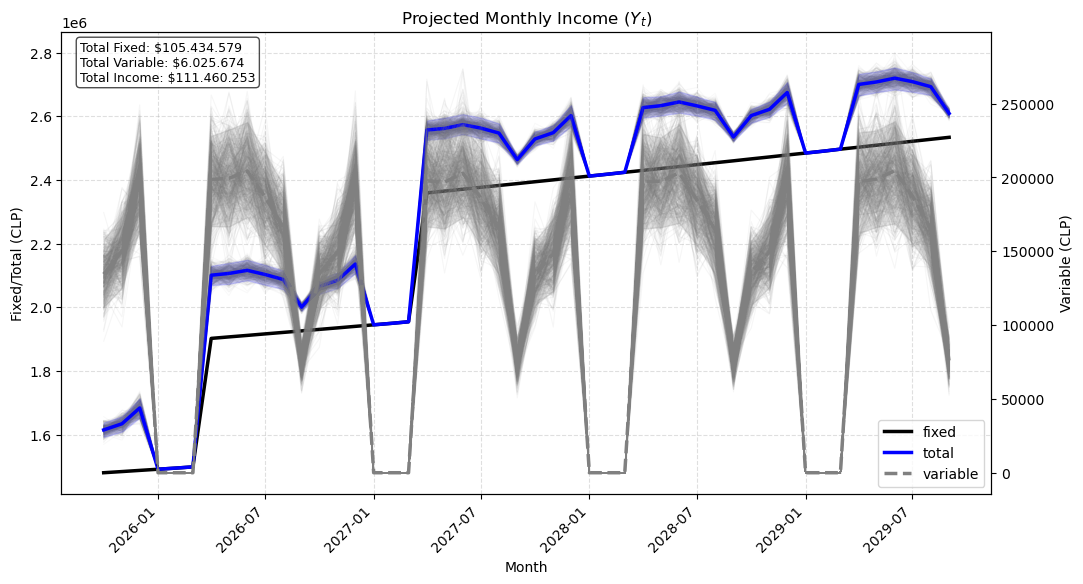

In [5]:
# Income Projection Simulation
model.plot(mode='income', T=months, start=start_date)

## Contribution Projection

A fraction of income is allocated each month through calendar-rotating schedules:
$$
A_t = \alpha_{(t + \text{offset}) \bmod 12}^{f} \cdot y_t^{\text{fixed}} + \alpha_{(t + \text{offset}) \bmod 12}^{v} \cdot Y_t^{\text{variable}}
$$

where $\alpha^f, \alpha^v \in [0,1]^{12}$ control the fixed and variable contribution rates by applying the 12-month fractional arrays to projected incomes, rotated according to `start` date and repeated cyclically for horizons > 12 months.

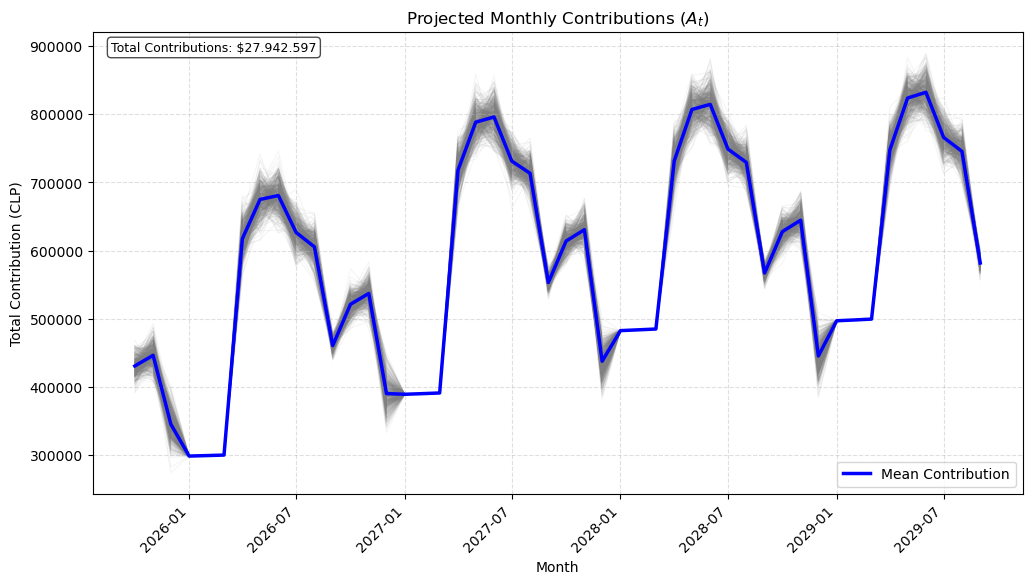

In [6]:
# Contribution Projection Simulation
model.plot(mode='contributions', T=months, start=start_date)

# Return Module

## Multi-Account Return Model

For $M$ accounts with correlated returns:

$$1 + R_t^m \sim \text{LogNormal}(\mu_{\log}^m, \Sigma)$$

where $\Sigma = D \cdot \rho \cdot D$ is the covariance matrix:
- $D = \text{diag}(\sigma_{\log}^1, \ldots, \sigma_{\log}^M)$
- $\rho \in \mathbb{R}^{M \times M}$ is the correlation matrix (symmetric, PSD)



## Monthly Return Distribution (Marginal Analysis)

Visualizes IID monthly returns across both accounts with 4 panels:
- **Trajectories**: Individual paths for each account
- **Histograms**: Marginal distributions (overlaid)
- **Statistics**: Mean, std, quantiles per account

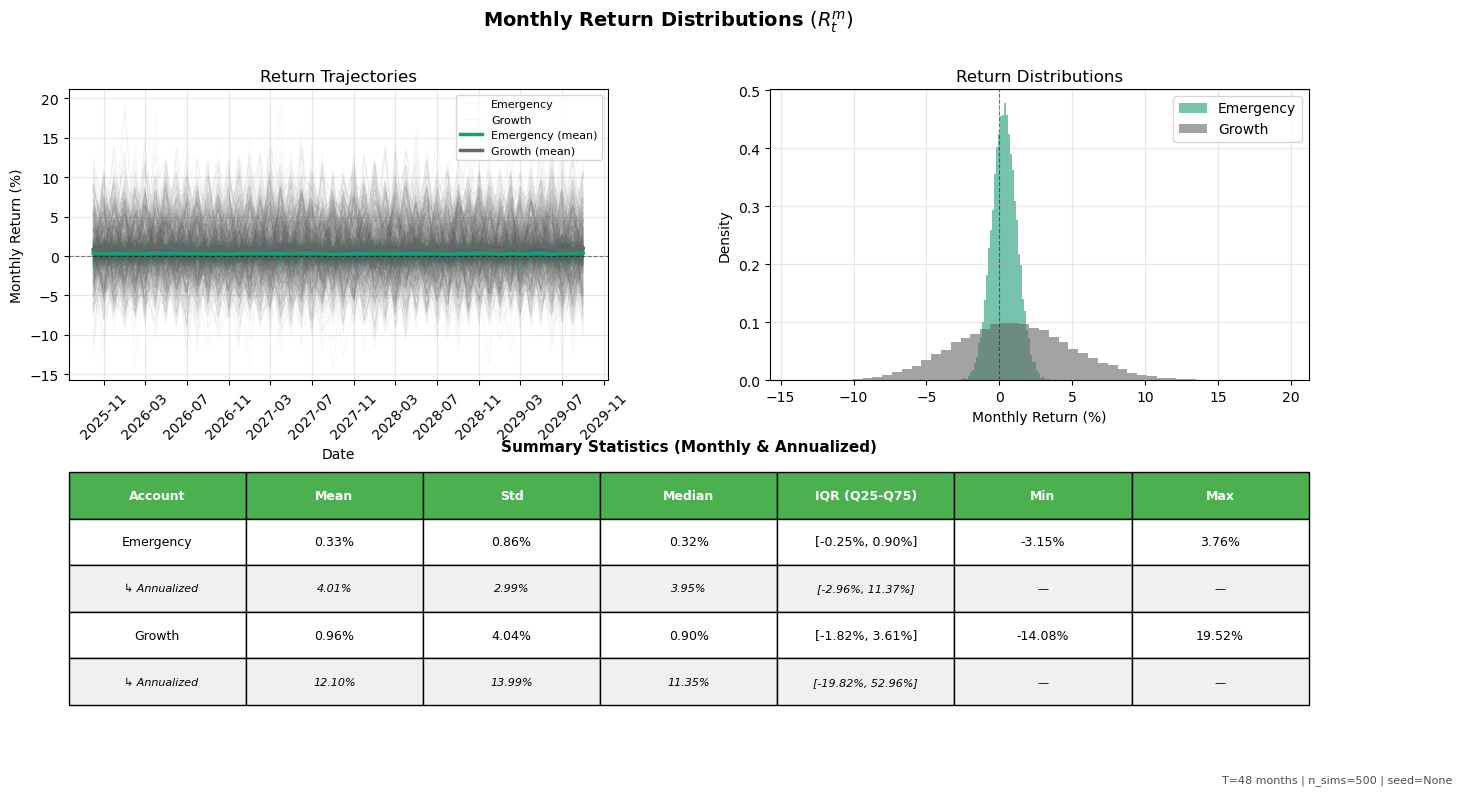

In [7]:
model.plot(mode = 'returns', T = months, start=start_date)

## Cumulative Returns per Account

For $M$ accounts with correlated returns:
$$R_{\text{cm}}^m(T) = \prod_{t=0}^{T-1}(1 + R_t^m) - 1$$
**Cross-sectional correlation** persists through time but does not compound.

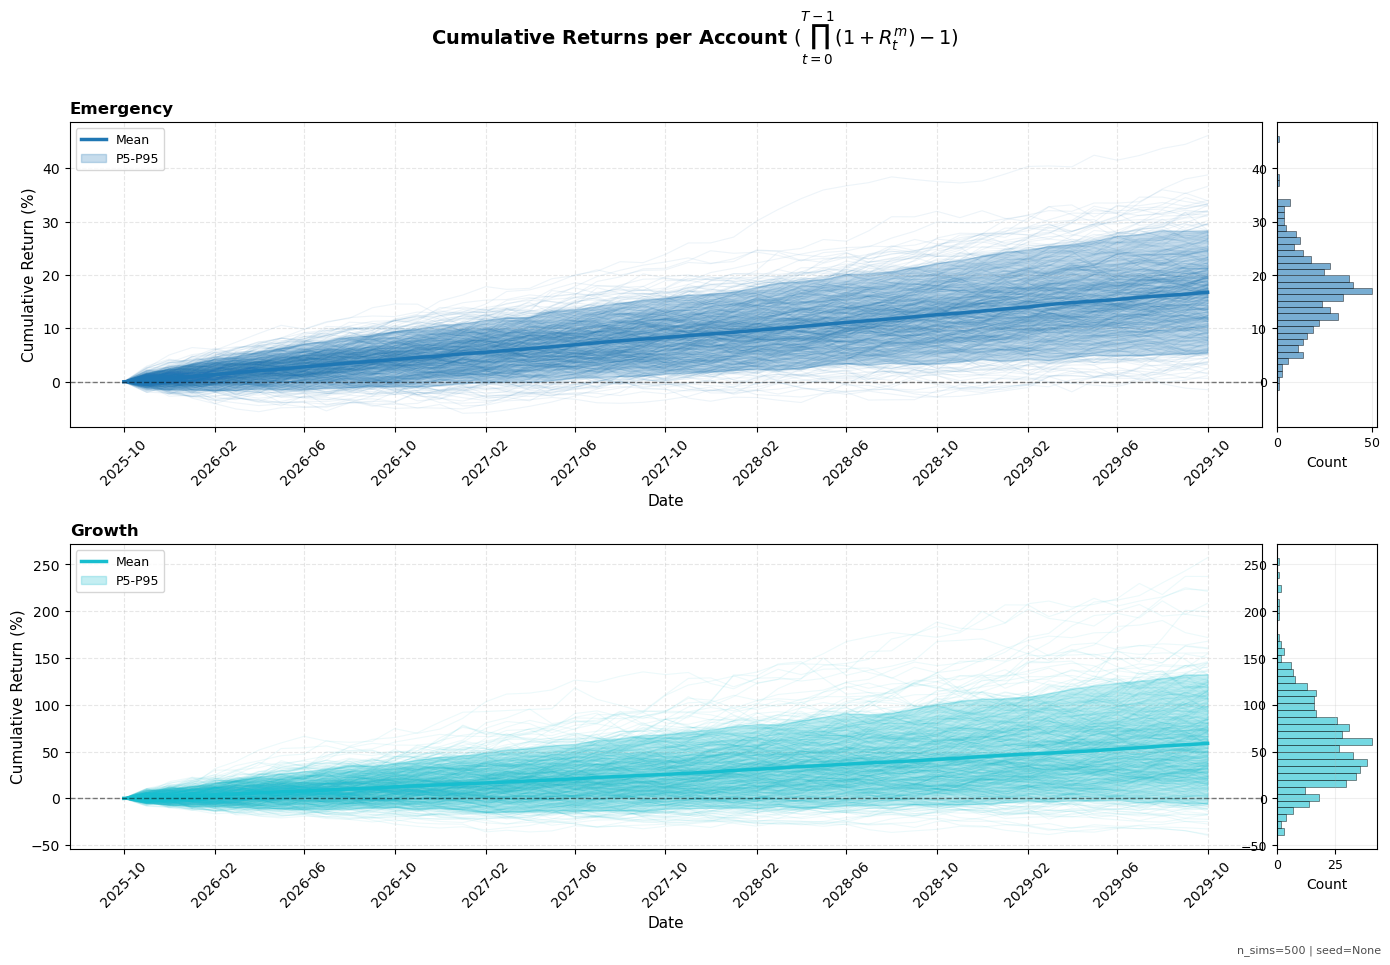

In [8]:
model.plot(mode = 'returns_cumulative', T = months, start=start_date)

## Horizon Analysis: Time Diversification by Account


HORIZON ANALYSIS - Emergency
 Horizon |  Expected | Volatility |  P(Loss) |    P25-P75 |    SNR
 (years) |    Return |      (±1σ) |          |      Range |       
-------------------------------------------------------------------------------------
    1.0  |      4.0% |       3.0% |     9.1% |       4.0% |  1.33
    2.0  |      8.2% |       4.2% |     2.7% |       5.7% |  1.92
    3.0  |     12.5% |       5.2% |     0.8% |       7.0% |  2.40
    5.0  |     21.7% |       6.7% |     0.1% |       9.0% |  3.23
   10.0  |     48.0% |       9.5% |     0.0% |      12.8% |  5.06
   15.0  |     80.1% |      11.6% |     0.0% |      15.7% |  6.89
   20.0  |    119.1% |      13.4% |     0.0% |      18.1% |  8.88

HORIZON ANALYSIS - Growth
 Horizon |  Expected | Volatility |  P(Loss) |    P25-P75 |    SNR
 (years) |    Return |      (±1σ) |          |      Range |       
-------------------------------------------------------------------------------------
    1.0  |     12.0% |      14.0% |    19

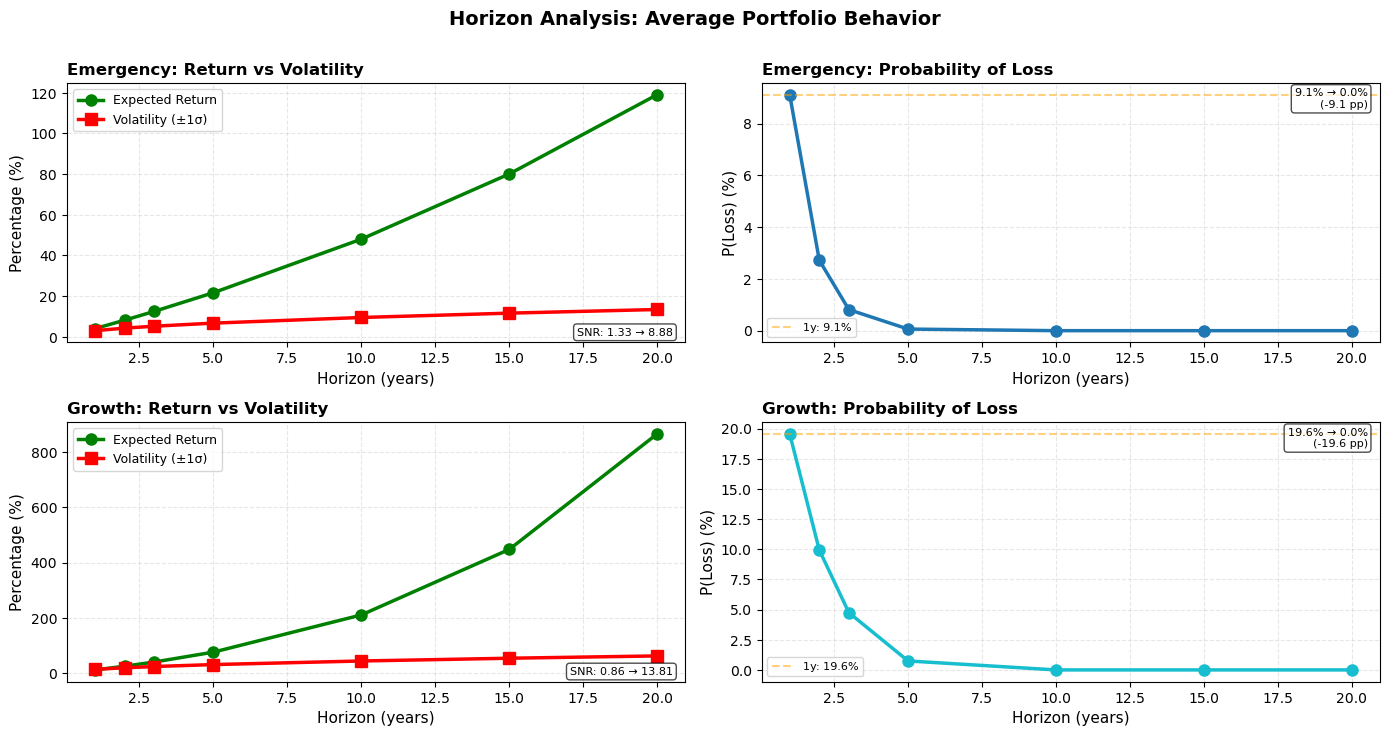

In [9]:
# --- Horizon analysis (average portfolio behavior) ---
mode = 'returns_horizon'
model.plot(mode = 'returns_horizon')

# Portfolio Module

## Wealth Projection Under Allocation Policy

**Recursive dynamics**: Wealth evolves as:
$$
W_{t+1}^m = (W_t^m + A_t^m) \,(1 + R_t^m)
$$
where $A_t^m = x_t^m \cdot A_t$ is the contribution allocated to account $m$ via policy $X = \{x_t^m\}_{t,m}$.

**Closed-form representation**:
$$
W_t^m = W_0^m \, F_{0,t}^m + \sum_{s=0}^{t-1} A_s \, x_s^m \, F_{s,t}^m
$$
with accumulation factor $F_{s,t}^m = \prod_{r=s}^{t-1} (1 + R_r^m)$.

**Key insight**: $W_t^m(X)$ is **linear affine in policy** $X$ → analytical gradients enable convex optimization.

**What to observe**:
- Top-left: wealth per account with Monte Carlo trajectories
- Top-right: total wealth + final distribution histogram
- Bottom-left: portfolio composition over time
- Bottom-right: allocation policy heatmap

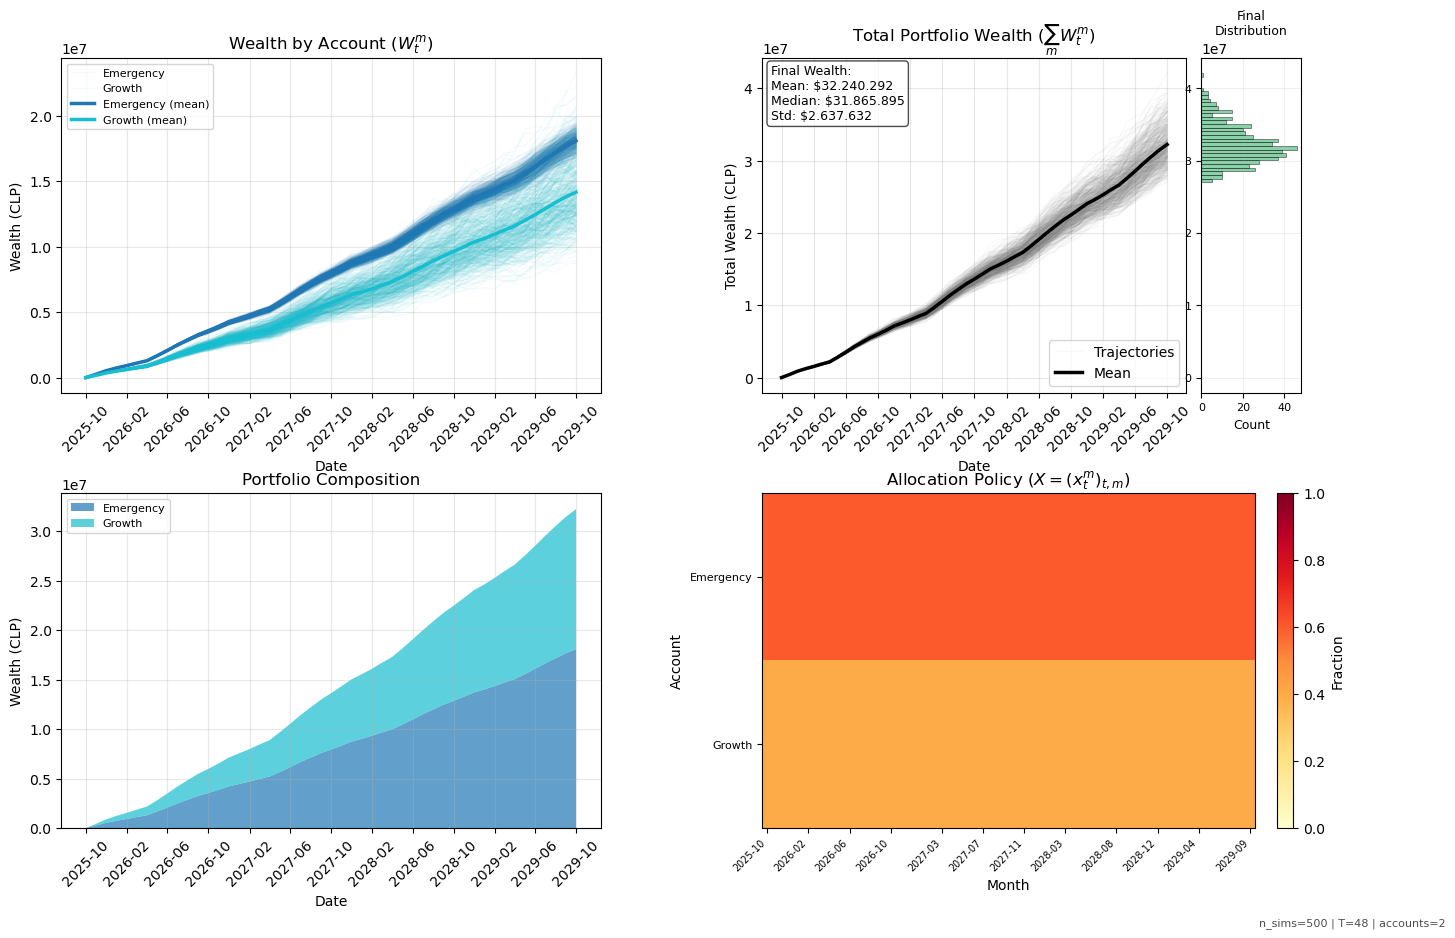

In [10]:
# Define Allocation Policy

# --- Static allocation: 60% Emergency, 40% Growth ---
X_static = np.tile([0.6, 0.4], (months, 1))  # shape (months, 2)

# Project monthly Wealth
model.plot(mode = 'wealth', start=start_date, T=months, X=X_static)